In [1]:
import numpy as np
import pandas as pd
import ot
import scipy as sp
import matplotlib.pyplot as plt


C:\Users\maria\anaconda3\Lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
def construct_interpolated_point_cloud(P, Q, kappa, T):
    # Step 1: Initialization
    k = 1
    T_prime = np.copy(T)
    
    # Step 2: Loop for Vanishing Points
    for i, ui in enumerate(T.sum(axis=1)):
        if ui > 0:
            # If the i-th row sum in T is zero, add a vanishing point
            if np.linalg.norm(T[i, :], ord=1) == 0:
                rk = (1 - kappa) * ui
                zk = P[i, 1:4]  # Static position
                k += 1
            else:
                # Redistribute the transport plan T'
                T_prime[i, :] += (1 - kappa) * ui*T[i,:] / np.linalg.norm(T[i, :],ord=1)

    # Step 3: Loop for Appearing Points
    for j, vj in enumerate(T.sum(axis=0)):
        if vj > 0:
            # If the j-th column sum in T is zero, add an appearing point
            if np.linalg.norm(T[:, j],ord=1) == 0:
                rk = kappa * vj
                zk = Q[j, 1:4]  # Static position
                k += 1
            else:
                # Redistribute the transport plan T'
                T_prime[:, j] += kappa * vj * T[:,j]/ np.linalg.norm(T[:, j],ord=1)

#     # Step 4: Loop for Moving Points
# #     for i, j in zip(*np.where(T_prime > 0)):
# #         # Add a moving point
# #         rk = T_prime[i, j]
# #         zk = (1 - kappa) * P[i, :] + kappa * Q[j, :]  # Position interpolation
# #         k += 1

#     print(T_prime[0])

    # Step 4: Loop for Moving Points
    rk_list = []
    zk_list = []

    for i, j in zip(*np.where(T_prime > 0)):
        # Add a moving point
        rk = T_prime[i, j]
        zk = (1 - kappa) * P[i, 1:4] + kappa * Q[j, 1:4] 
        rk_list.append(rk)
        zk_list.append(zk)
                
#     # Step 5: Return Result
    Rb = np.column_stack((np.array(rk_list), np.array(zk_list)))
    return Rb


In [3]:
p0 = pd.read_csv(r'C:\Users\maria\OneDrive\Documenten\Master\R&D\interpolation\csv\csv\pressure2.csv')
x0= pd.read_csv(r'C:\Users\maria\OneDrive\Documenten\Master\R&D\interpolation\csv\csv\doa2.csv')
p2 = pd.read_csv(r'C:\Users\maria\OneDrive\Documenten\Master\R&D\interpolation\csv\csv\pressure16.csv')
x2= pd.read_csv(r'C:\Users\maria\OneDrive\Documenten\Master\R&D\interpolation\csv\csv\doa16.csv')

p0=p0[0:40000]
x0=x0[0:40000]
p2=p2[0:40000]
x2=x2[0:40000]

p0=p0.to_numpy()
p2=p2.to_numpy()
x0=x0.to_numpy()
x2=x2.to_numpy()


# Display shapes of the arrays
print(f"p0 shape: {p0.shape}, p2 shape: {p2.shape}, x0 shape: {x0.shape}, x2 shape: {x2.shape}")


p0 shape: (40000, 1), p2 shape: (40000, 1), x0 shape: (40000, 3), x2 shape: (40000, 3)


In [4]:
def window_samples(samples, window_size, overlap_percentage):

    overlap_samples = int(window_size * overlap_percentage / 100)

    windows = []

    for i in range(0, len(samples), window_size - overlap_samples):
        window = samples[i:i + window_size]
        windows.append(window)

    return windows

In [5]:
winSize=2000
overlap=0

p0_windowed=window_samples(p0, winSize, overlap)
x0_windowed=window_samples(x0, winSize, overlap)
p2_windowed=window_samples(p2, winSize, overlap)
x2_windowed=window_samples(x2, winSize, overlap)



In [6]:

def split_pos_neg(p):
    p_pos_full = np.zeros_like(p)
    p_neg_full = np.zeros_like(p)
    
    p_pos_indices = np.where(p > 0)[0]
    p_neg_indices = np.where(p < 0)[0]
    
    p_pos_full[p_pos_indices] = p[p_pos_indices]
    p_neg_full[p_neg_indices] = p[p_neg_indices]
    
    p_neg_full=np.abs(p_neg_full)   

    
    return p_pos_full, p_neg_full




In [7]:
p0_w_pos=[]
p0_w_neg=[]
p2_w_pos=[]
p2_w_neg=[]

p0_pos_sum_w=[]
p0_neg_sum_w=[]
p2_pos_sum_w=[]
p2_neg_sum_w=[]


for p0 in p0_windowed:
    p0_pos, p0_neg=split_pos_neg(p0)
    p0_w_pos.append(p0_pos)
    p0_w_neg.append(p0_neg)


for p2 in p2_windowed:
    p2_pos, p2_neg=split_pos_neg(p2)
    p2_w_pos.append(p2_pos)
    p2_w_neg.append(p2_neg)

    


In [8]:
M_windowed=[]

for x0, x2 in zip(x0_windowed, x2_windowed):
    M=ot.dist(x0,x2)
    M_windowed.append(M)
    

In [9]:
def preprocessing(p):
    p=p.flatten()
    p_sum=np.sum(p)
    p=p/p_sum
    return p, p_sum
    

In [10]:
w0_pos=[]
w0_neg=[]
i=0

for p0, p2, M in zip(p0_w_pos, p2_w_pos, M_windowed):
    p0_prerocessed, p0_pos_sum=preprocessing(p0)
    p0_pos_sum_w.append(p0_pos_sum)
    p2_prerocessed, p2_pos_sum=preprocessing(p2)
    p2_pos_sum_w.append(p2_pos_sum)
    w_pos= ot.partial.partial_wasserstein(p0_prerocessed,p2_prerocessed, M,m=0.9,nb_dummies = 100)
    w0_pos.append(w_pos)
    
for p0, p2, M in zip(p0_w_neg, p2_w_neg, M_windowed):
    p0_prerocessed, p0_neg_sum=preprocessing(p0)
    p0_neg_sum_w.append(p0_neg_sum)
    p2_prerocessed, p2_neg_sum=preprocessing(p2)
    p2_neg_sum_w.append(p2_neg_sum)
    w_neg= ot.partial.partial_wasserstein(p0_prerocessed, p2_prerocessed, M,m=0.9,nb_dummies = 100)
    w0_neg.append(w_neg)
    
    
    

In [11]:
P_pos_w=[]
P_neg_w=[]
Q_pos_w=[]
Q_neg_w=[]

for p0_pos, x0 in zip(p0_w_pos,x0_windowed):
    P_pos_w.append(np.column_stack((p0_pos,x0)))
for p0_neg, x0 in zip(p0_w_neg,x0_windowed):
    P_neg_w.append(np.column_stack((p0_neg,x0)))
for p2_pos, x2 in zip(p2_w_pos,x2_windowed):
    Q_pos_w.append(np.column_stack((p2_pos,x2)))
for p2_neg, x2 in zip(p2_w_neg,x2_windowed):
    Q_neg_w.append(np.column_stack((p2_neg,x2)))
    


In [12]:
r_pos_w=[]
r_neg_w=[]

for P, Q, w in zip(P_pos_w, Q_pos_w, w0_pos):
    r_pos=construct_interpolated_point_cloud(P, Q, 0.5, w)
    r_pos_w.append(r_pos)
    
for P, Q, w in zip(P_neg_w, Q_neg_w, w0_neg):
    r_neg=construct_interpolated_point_cloud(P, Q, 0.5, w)
    r_neg_w.append(r_neg)
    


In [13]:
pressure_pos=[]
x_pos=[]
y_pos=[]
z_pos=[]
doa_pos=[]

pressure_neg=[]
x_neg=[]
y_neg=[]
z_neg=[]
doa_neg=[]


for r_pos, p0_pos_sum, p2_pos_sum in zip(r_pos_w, p0_pos_sum_w, p2_pos_sum_w ):
    
    pressure_pos.append(r_pos[:, 0]*((p0_pos_sum+p2_pos_sum)/2))
    x_pos.append(r_pos[:, 1])
    y_pos.append(r_pos[:, 2]) 
    z_pos.append(r_pos[:, 3])
    doa_pos.append(r_pos[:,1:4])
    
for r_neg, p0_sum_neg, p2_sum_neg in zip(r_neg_w, p0_neg_sum_w, p2_neg_sum_w):
    
    pressure_neg.append(r_neg[:, 0]*(p0_sum_neg+p2_sum_neg)*(-0.5))
    x_neg.append(r_neg[:, 1])
    y_neg.append(r_neg[:, 2]) 
    z_neg.append(r_neg[:, 3])
    doa_neg.append(r_neg[:,1:4])
    


In [14]:
all_pressures= np.concatenate(pressure_pos + pressure_neg)
x = np.concatenate(x_pos+x_neg)
y=np.concatenate(y_pos+y_neg)
z=np.concatenate(z_pos+z_neg)
doa=np.concatenate(doa_pos+doa_neg)


x_neg=np.concatenate(x_neg)
y_neg=np.concatenate(y_neg)
z_neg=np.concatenate(z_neg)
pressure_neg=np.concatenate(pressure_neg)
doa_neg=np.concatenate(doa_neg)

x_pos=np.concatenate(x_pos)
y_pos=np.concatenate(y_pos)
z_pos=np.concatenate(z_pos)
pressure_pos=np.concatenate(pressure_pos)
doa_pos=np.concatenate(doa_pos)


<IPython.core.display.Javascript object>


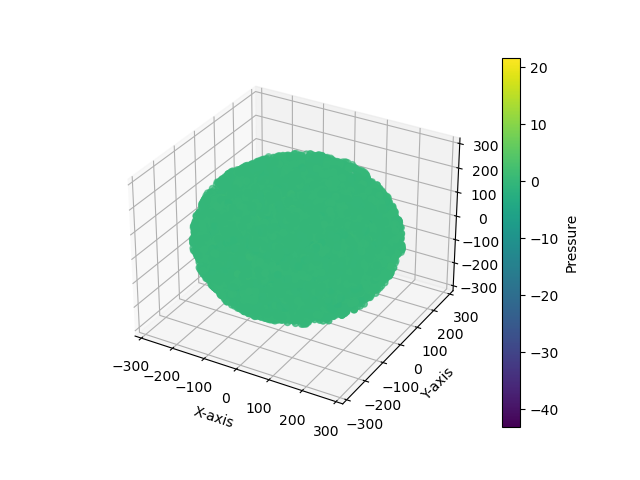

In [16]:
%matplotlib notebook
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing pressure values
sc = ax.scatter(x, y, z, c=all_pressures, cmap='viridis', marker='o')

# Set labels for each axis
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Add a colorbar
cbar = plt.colorbar(sc, label='Pressure')

# Show the plot
plt.show()

36315
36083


<IPython.core.display.Javascript object>


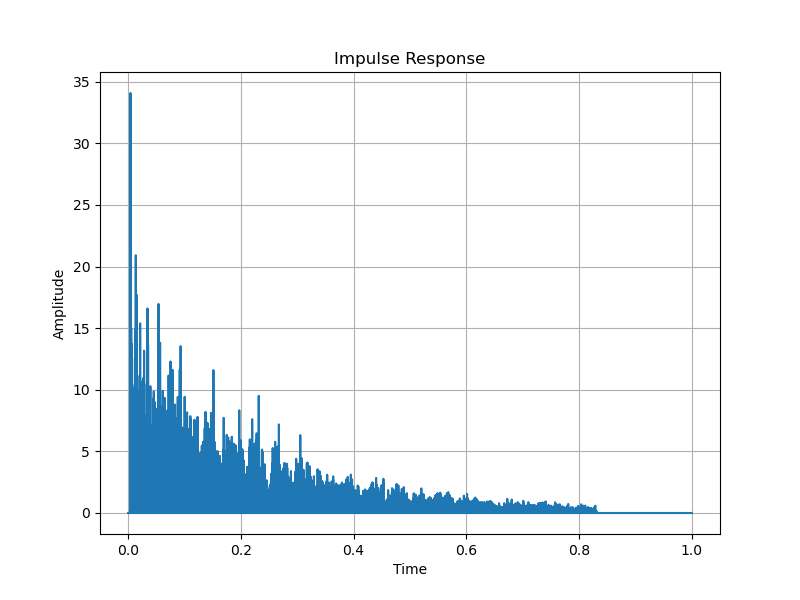

<IPython.core.display.Javascript object>


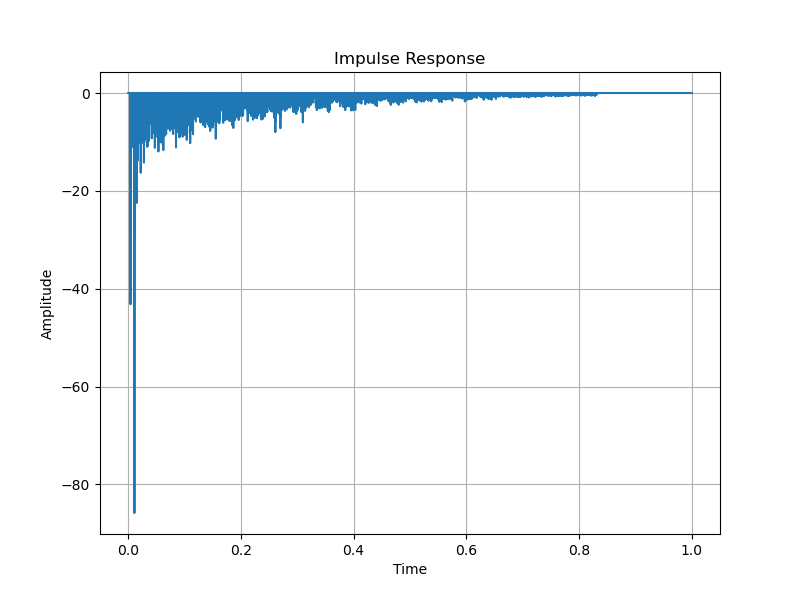

<IPython.core.display.Javascript object>


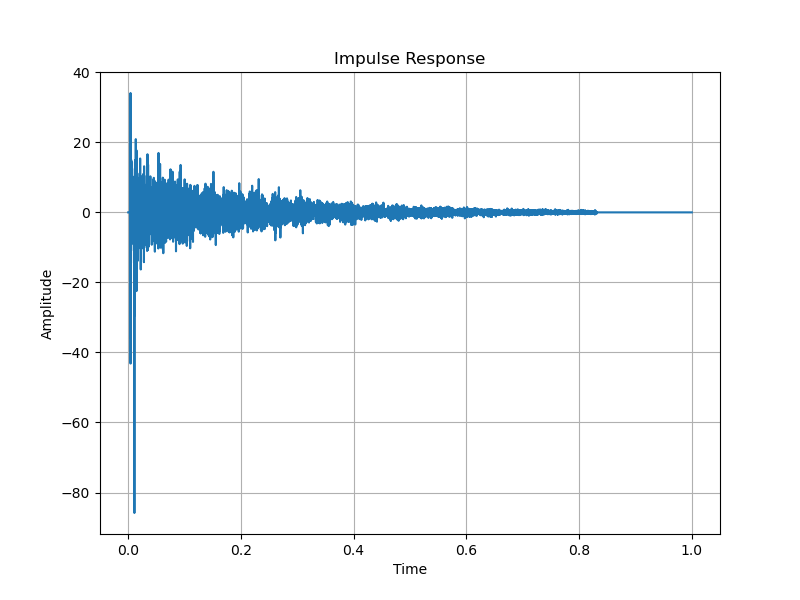

In [17]:
c = 343  # Speed of sound

# Calculate the L2 norm for each x value
norms_pos = np.linalg.norm(doa_pos, axis=1)
norms_neg = np.linalg.norm(doa_neg, axis=1)


# Calculate time shifts
time_shifts_pos = norms_pos / c
time_shifts_neg = norms_neg / c


print(len(pressure_pos))
print(len(pressure_neg))


dur=min(len(pressure_pos), len(pressure_neg))

# Create the impulse response
time = np.linspace(0, 1, 400000)  # Assuming a time range from 0 to 1 (adjust as needed)
impulse_response_pos = np.zeros_like(time)
impulse_response_neg = np.zeros_like(time)
impulse_response = np.zeros_like(time)


# Add positive pressures to impulse_response_pos
for i in range(len(pressure_pos)):
    index = np.searchsorted(time, time_shifts_pos[i])
    
    # Add the pressure value to the closest time point
    impulse_response_pos[index] += pressure_pos[i]

# Add negative pressures to impulse_response_neg
for j in range(len(pressure_neg)):
    index = np.searchsorted(time, time_shifts_neg[j])
    
    # Add the pressure value to the closest time point
    impulse_response_neg[index] += pressure_neg[j]




# for i in range(len(pressure_pos)):
#     impulse_response_pos += pressure_pos[i] * np.isclose(time, time_shifts[i], atol=1e-5)
    
    
# for j in range(len(pressure_neg)):
#     impulse_response_neg += pressure_neg[j] * np.isclose(time, time_shifts[j], atol=1e-5)
    

# Plotting the Impulse Response
plt.figure(figsize=(8, 6))
plt.plot(time, impulse_response_pos)
plt.title('Impulse Response')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plotting the Impulse Response
plt.figure(figsize=(8, 6))
plt.plot(time, impulse_response_neg)
plt.title('Impulse Response')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

impulse_response=impulse_response_pos+impulse_response_neg

# Plotting the Impulse Response
plt.figure(figsize=(8, 6))
plt.plot(time, impulse_response)
plt.title('Impulse Response')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



In [18]:
import sounddevice as sd
sample_rate = 48000
duration = 2
sd.play(impulse_response, sample_rate)
sd.wait() 

In [19]:
import soundfile as sf
sf.write("interpolated.wav", impulse_response, sample_rate)

<IPython.core.display.Javascript object>


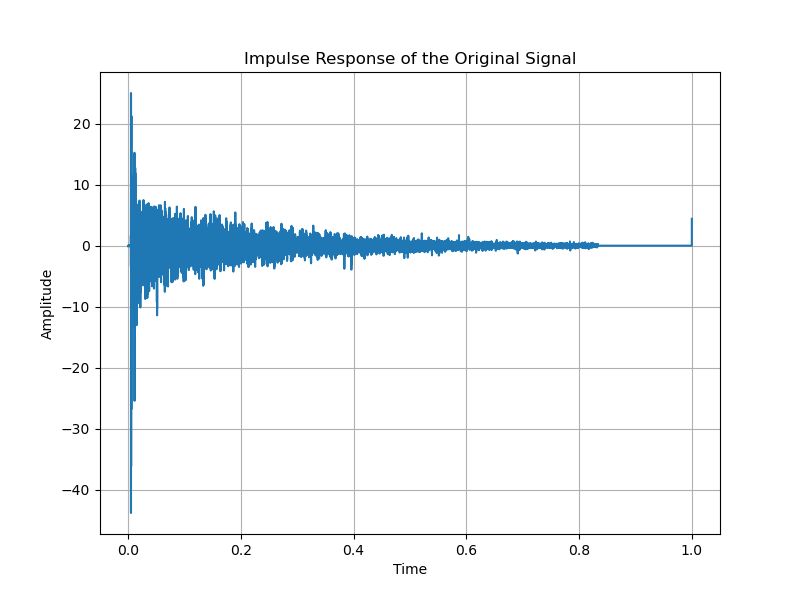

In [20]:
#impulse response original

df_pos = pd.read_csv(r'C:\Users\maria\OneDrive\Documenten\Master\R&D\interpolation\csv\csv\doa3.csv')
df_pressure = pd.read_csv(r'C:\Users\maria\OneDrive\Documenten\Master\R&D\interpolation\csv\csv\pressure3.csv')


df_pos_subset = df_pos.iloc[0:40000]
df_pressure_subset = df_pressure.iloc[0:40000]


doas_og = df_pos_subset.values
pressures_og = df_pressure_subset.values

c = 343  # Speed of sound

# Calculate the L2 norm for each x value
norms = np.linalg.norm(doas_og, axis=1)

# Calculate time shifts
time_shifts = norms / c

# Create the impulse response
time = np.linspace(0, 1, 400000)  # Assuming a time range from 0 to 1 (adjust as needed)
impulse_response_og = np.zeros_like(time)



for i in range(len(pressures_og)):
    index = np.searchsorted(time, time_shifts[i])
    #print(index)
    # Clip the index to ensure it is within the valid range
    index = np.clip(index, 0, len(time) - 1)
    # Add the pressure value to the closest time point
    impulse_response_og[index] += pressures_og[i]

# Plotting the Impulse Response
plt.figure(figsize=(8, 6))
plt.plot(time, impulse_response_og)
plt.title('Impulse Response of the Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [21]:
print(len(impulse_response), len(impulse_response_og))

400000 400000


Time lag: 413 samples


<IPython.core.display.Javascript object>


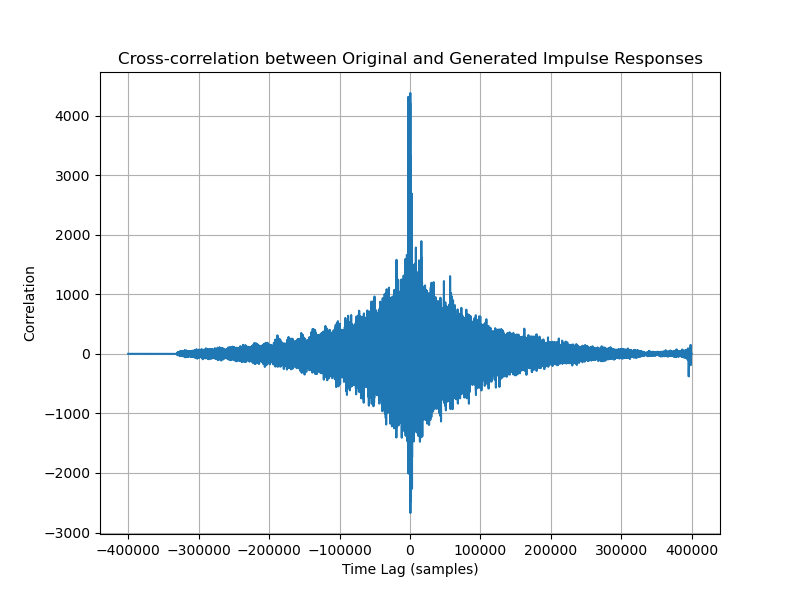

In [22]:
# Compute the cross-correlation between the generated impulse response and the original measured impulse response
cross_corr = np.correlate(impulse_response_og, impulse_response, mode='full')

# Calculate the time lag corresponding to the maximum correlation
time_lag = np.argmax(cross_corr) - (len(impulse_response) - 1)

print(f"Time lag: {time_lag} samples")

# Create a time axis for the cross-correlation plot
time_axis = np.arange(-len(impulse_response) + 1, len(impulse_response))

# Plot the cross-correlation result
plt.figure(figsize=(8, 6))
plt.plot(time_axis, cross_corr)
plt.title('Cross-correlation between Original and Generated Impulse Responses')
plt.xlabel('Time Lag (samples)')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


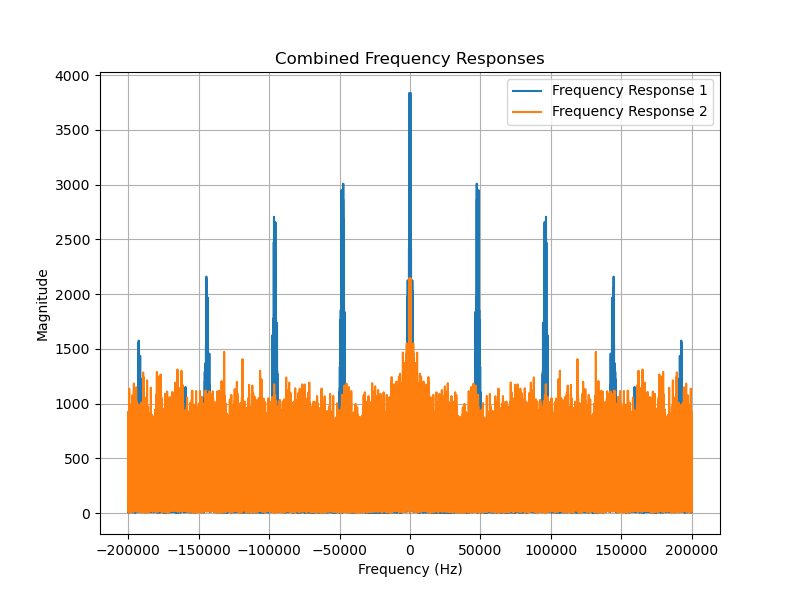

In [23]:
frequency_response = np.fft.fft(impulse_response)

frequency_response_og = np.fft.fft(impulse_response_og)


# Calculate the corresponding frequencies
sampling_rate = 1 / (time[1] - time[0])
frequencies = np.fft.fftfreq(len(impulse_response), d=1/sampling_rate)



# Plot the magnitude of the frequency responses
plt.figure(figsize=(8, 6))

# Plot the first frequency response
plt.plot(frequencies, np.abs(frequency_response_og), label='Frequency Response 1')

# Plot the second frequency response
plt.plot(frequencies, np.abs(frequency_response), label='Frequency Response 2')

plt.title('Combined Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.show()